In [2]:
import numpy as np
import pickle
from scipy.io import savemat, loadmat
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score
from matplotlib.colors import Normalize
import sys
sys.path.insert(0, "/Users/bengieru/MLN/Results/general_diagnostics_00/")

from helpers import *
import matplotlib.pyplot as plt
import pickle
from math import floor
import random
import matplotlib as mpl

In [3]:
def generate_ground_truth(comm_sizes, method = 'scattered', pad = False, community_operation = 'grow'):
    ##genertaes community labels according to two methods one in which the rest of the network except the planted communities
    # are scattered i.e. they all have their own community or they are all in one community, integrated.
    if community_operation == 'grow':
        layers = len(comm_sizes)
        if method == 'scattered':
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + list(np.arange(1, sum(comm_sizes[1:])+1))
            
            truth_labels_tip = truth_labels
                     
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + truth_labels_tip[sum(comm_sizes[:j]):]
            
            truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
            
            if pad:
                truth_labels = truth_labels_tip + truth_labels
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]  
        
        if method == 'integrated':
        
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + [1 for i in range(sum(comm_sizes[1:]))]
            if pad: truth_labels = truth_labels + truth_labels
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + [1 for i in range(sum(comm_sizes[j:]))]

            if pad:
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                
    elif community_operation == 'merge': ##only for two layers
        truth_labels = []
        
        for j,f in enumerate(comm_sizes[0]):
            truth_labels = truth_labels + [j for k in range(f)]
    
        for j,f in enumerate([6,3,7]):##communities that are merged in the first layer are assigned one of the labels of 
            #merged communities 
            truth_labels = truth_labels + [f for i in range(comm_sizes[1][j])]
            
        if pad:
            l1 = truth_labels[:sum(comm_sizes[0])]
            l2 = truth_labels[sum(comm_sizes[0]):]
            truth_labels = l1 + truth_labels +l2
    return(truth_labels)

# load dppm

In [3]:
G_ESCR_comm_size_dppm = [11,16,9,9,9,14,12]
num_neurons = sum(G_ESCR_comm_size_dppm)
threshs = np.linspace(0.05,0.5,10)
path = '/Users/bengieru/MLN/Results/Comparison/G_ESCR/DPPM/'

In [4]:
communities = loadmat(path + 'communitites_G_ESCR.mat')
vertices = loadmat(path + 'vertices_G_ESCR.mat')

In [5]:
labels_k_2 = {}
labels_k_3 = {}
for i,e in enumerate(threshs):
    li2 = []
    li3 = []
    for j in range(9):
        overlapping_partition2 = random.randint(0,vertices['v_G_ESCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = random.randint(0,vertices['v_G_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        li2 = li2 + list(vertices['v_G_ESCR'][0][0][i][0][0][0][j][overlapping_partition2])
        li3 = li3 + list(vertices['v_G_ESCR'][0][0][i][0][1][0][j][overlapping_partition3])
    labels_k_2['%d'%i] = li2
    labels_k_3['%d'%i] = li3

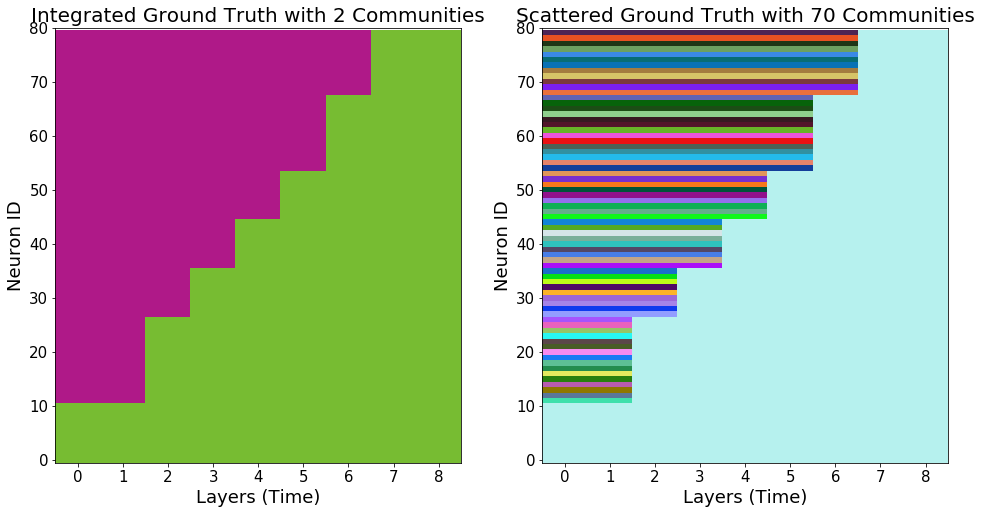

In [6]:
display_truth(G_ESCR_comm_size_dppm, 'grow')

# load mmm

In [3]:
path = '/Users/bengieru/MLN/Results/Comparison/G_ESCR/'

interlayers = np.linspace(0, 1.50, 51)
resolutions = np.linspace(0, 1.50, 51)

with open(path + 'MMM_labels_no_update.pkl', 'rb') as handle:
    G_ESCR_labels0_mmm = pickle.load(handle)
    
with open(path + 'comm_size.pkl', 'rb') as handle:
    G_ESCR_comm_size_mmm = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    G_ESCR_spikes_mmm = pickle.load(handle)

In [14]:
G_ESCR_labels0_mmm.shape

(2601, 1125)

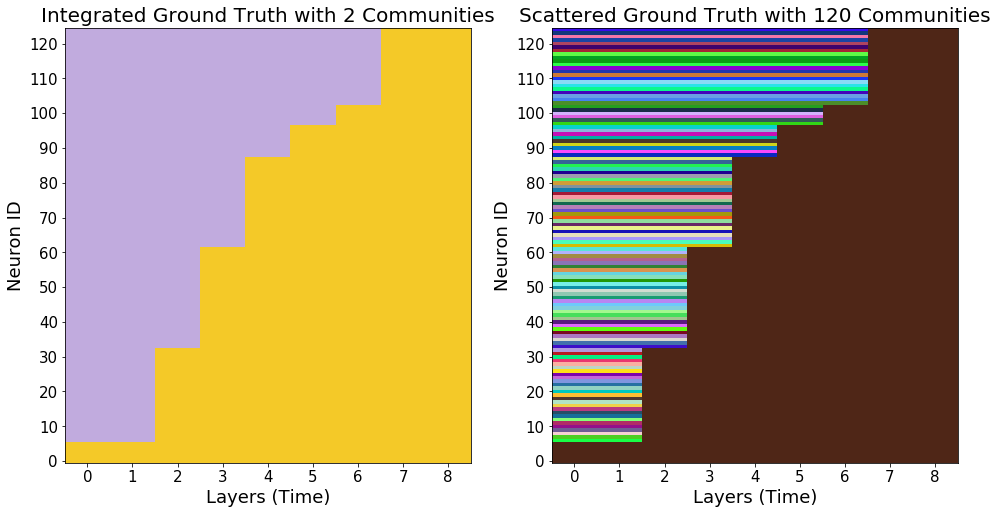

In [4]:
display_truth(G_ESCR_comm_size_mmm, community_operation = 'grow')

## Load Infomap

In [9]:
path = '/Users/bengieru/MLN/Results/Comparison/G_ESCR/'

grid = 51
thresholds = np.linspace(0, 0.8, grid)
inters = np.linspace(0, 1.5, grid)

with open(path + 'infomap_labels_no_update.pkl', 'rb') as handle:
    G_ESCR_labels0_infomap = pickle.load(handle)
    
with open(path + 'comm_size.pkl', 'rb') as handle:
    G_ESCR_comm_size_infomap = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    G_ESCR_spikes_infomap = pickle.load(handle)

## Compare 3 of 'em

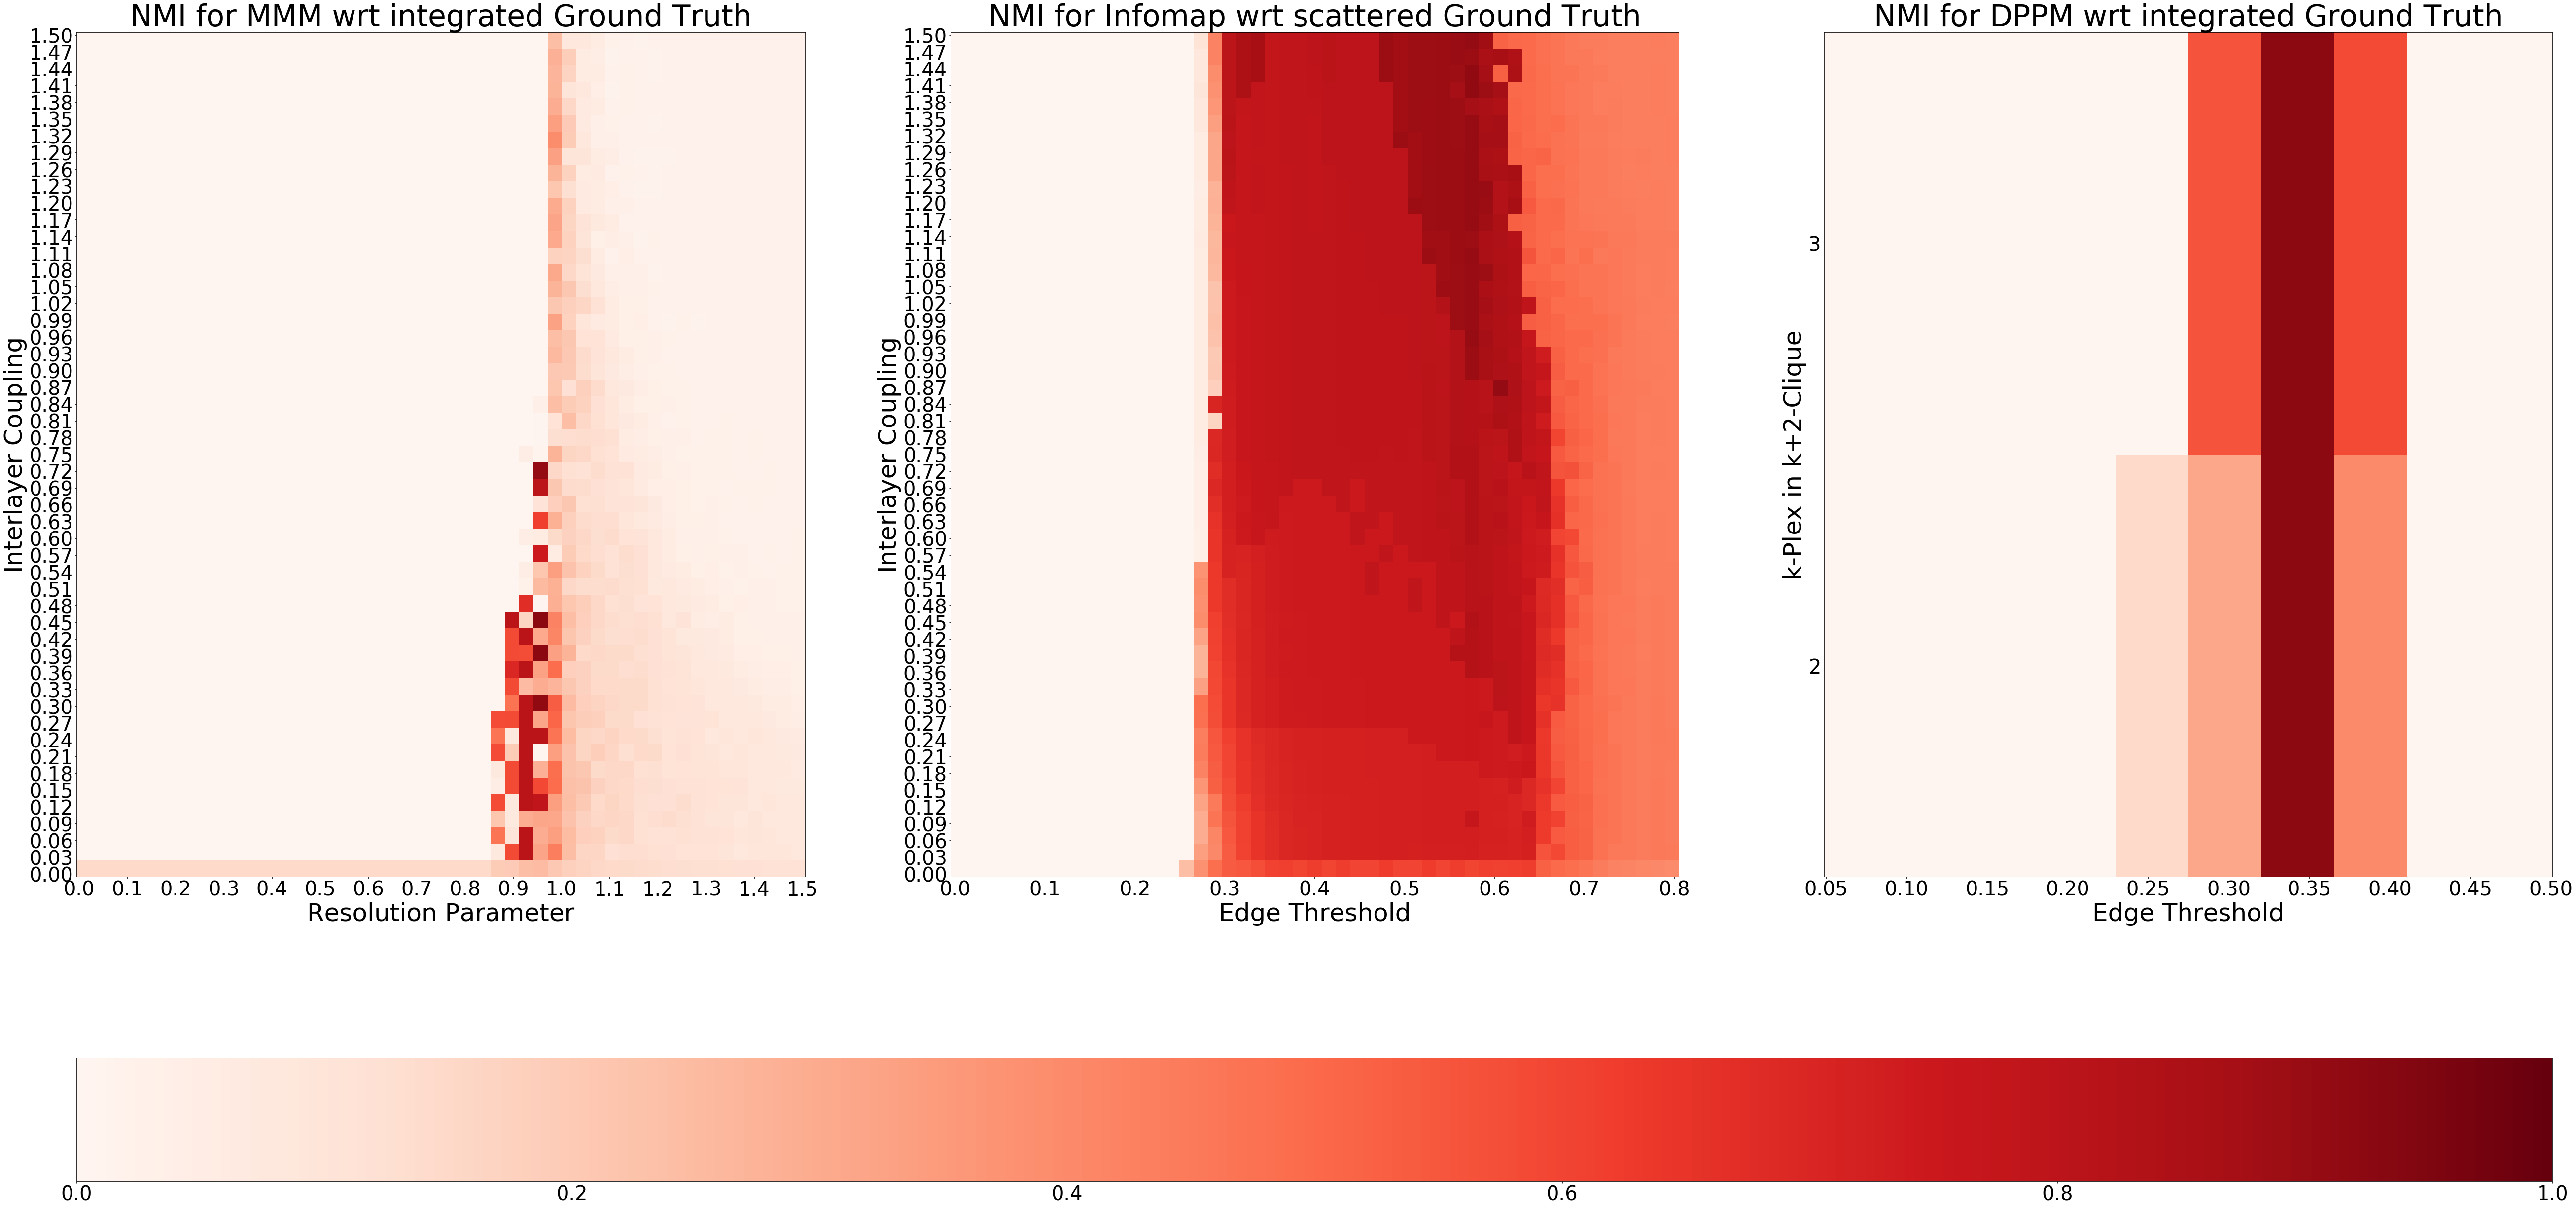

In [10]:
NMI1_mmm = np.zeros((len(interlayers), len(resolutions)))
NMI1_infomap = np.zeros((len(inters), len(thresholds)))
NMI1_dppm = np.zeros((2, len(threshs)))

truth1 = 'integrated'
truth2 = 'scattered'

true_labels_scat_info = generate_ground_truth(G_ESCR_comm_size_infomap, method = 'scattered', pad = True, community_operation = 'grow')
true_labels_integ_mmm = generate_ground_truth(G_ESCR_comm_size_mmm, method = 'integrated', pad = True, community_operation = 'grow')
true_labels_integ_dppm = generate_ground_truth(G_ESCR_comm_size_dppm, method = 'integrated', pad = True, community_operation = 'grow')


for j in range(len(threshs)-2):
    NMI1_dppm[0][j] = normalized_mutual_info_score(true_labels_integ_dppm, labels_k_2['%d'%j], average_method = 'max')
    NMI1_dppm[1][j] = normalized_mutual_info_score(true_labels_integ_dppm, labels_k_3['%d'%j], average_method = 'max')
    
for i in range(len(interlayers)):
    for j in range(len(resolutions)):
        NMI1_mmm[i][j] = normalized_mutual_info_score(true_labels_integ_mmm, list(G_ESCR_labels0_mmm[i*len(resolutions)+j].astype(int)), average_method = 'max')

for i in range(len(inters)):
    for j in range(len(thresholds)):
        NMI1_infomap[i][j] = normalized_mutual_info_score(true_labels_scat_info, list(G_ESCR_labels0_infomap[i*len(thresholds)+j].astype(int)), average_method = 'max')

fig,ax = plt.subplots(1,3, figsize = (90, 45))


normalize = Normalize(vmin=0, vmax=1)


c = ax[0].imshow(NMI1_mmm, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[1].imshow(NMI1_infomap, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds[0]-0.005, thresholds[-1]+0.005, inters[0]-0.005, inters[-1]+0.005])


c = ax[2].imshow(NMI1_dppm, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [threshs[0]-0.001, threshs[-1]+0.001, 2-0.5, 3+0.5])


ax[0].set_title('NMI for MMM wrt %s Ground Truth'%truth1, fontsize = 60)
ax[0].set_xlabel('Resolution Parameter', fontsize = 50)
ax[0].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[0].set_xticks([i*0.1 for i in range(0,16)])
ax[0].set_yticks(interlayers)
ax[0].tick_params(axis = 'both', labelsize = 40)

ax[1].set_title('NMI for Infomap wrt %s Ground Truth'%truth2, fontsize = 60)
ax[1].set_xlabel('Edge Threshold', fontsize = 50)
ax[1].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[1].set_xticks([i*0.1 for i in range(0,9)])
ax[1].set_yticks(interlayers)
ax[1].tick_params(axis = 'both', labelsize = 40)

ax[2].set_title('NMI for DPPM wrt %s Ground Truth'%truth1, fontsize = 60)
ax[2].set_xlabel('Edge Threshold', fontsize = 50)
ax[2].set_ylabel('k-Plex in k+2-Clique', fontsize = 50)
ax[2].set_xticks([i*0.05 for i in range(1,11)])
ax[2].set_yticks([2,3])
ax[2].tick_params(axis = 'both', labelsize = 40)
    
cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 40) 

#plt.tight_layout()

In [14]:
np.savetxt('/Users/bengieru/MLN/Make_Figures/MMM_landscape.txt', NMI1_mmm, delimiter=',')
np.savetxt('/Users/bengieru/MLN/Make_Figures/Infomap_landscape.txt', NMI1_infomap, delimiter=',')
np.savetxt('/Users/bengieru/MLN/Make_Figures/DPPM_landscape.txt', NMI1_dppm, delimiter=',')

## Compare across Heuristics -MMM

In [6]:
path = '/Users/bengieru/MLN/Results/Comparison/G_ESCR/'

interlayers = np.linspace(0, 1.50, 51)
resolutions = np.linspace(0, 1.50, 51)

with open(path + 'MMM_labels_neighborhood_update.pkl', 'rb') as handle:
    G_ESCR_labels3_mmm = pickle.load(handle)
with open(path + 'MMM_labels_global_update.pkl', 'rb') as handle:
    G_ESCR_labels2_mmm = pickle.load(handle)
with open(path + 'MMM_labels_local_update.pkl', 'rb') as handle:
    G_ESCR_labels1_mmm = pickle.load(handle)
with open(path + 'MMM_labels_no_update.pkl', 'rb') as handle:
    G_ESCR_labels0_mmm = pickle.load(handle)
    
with open(path + 'comm_size.pkl', 'rb') as handle:
    G_ESCR_comm_sizes = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    G_ESCR_spikes = pickle.load(handle)

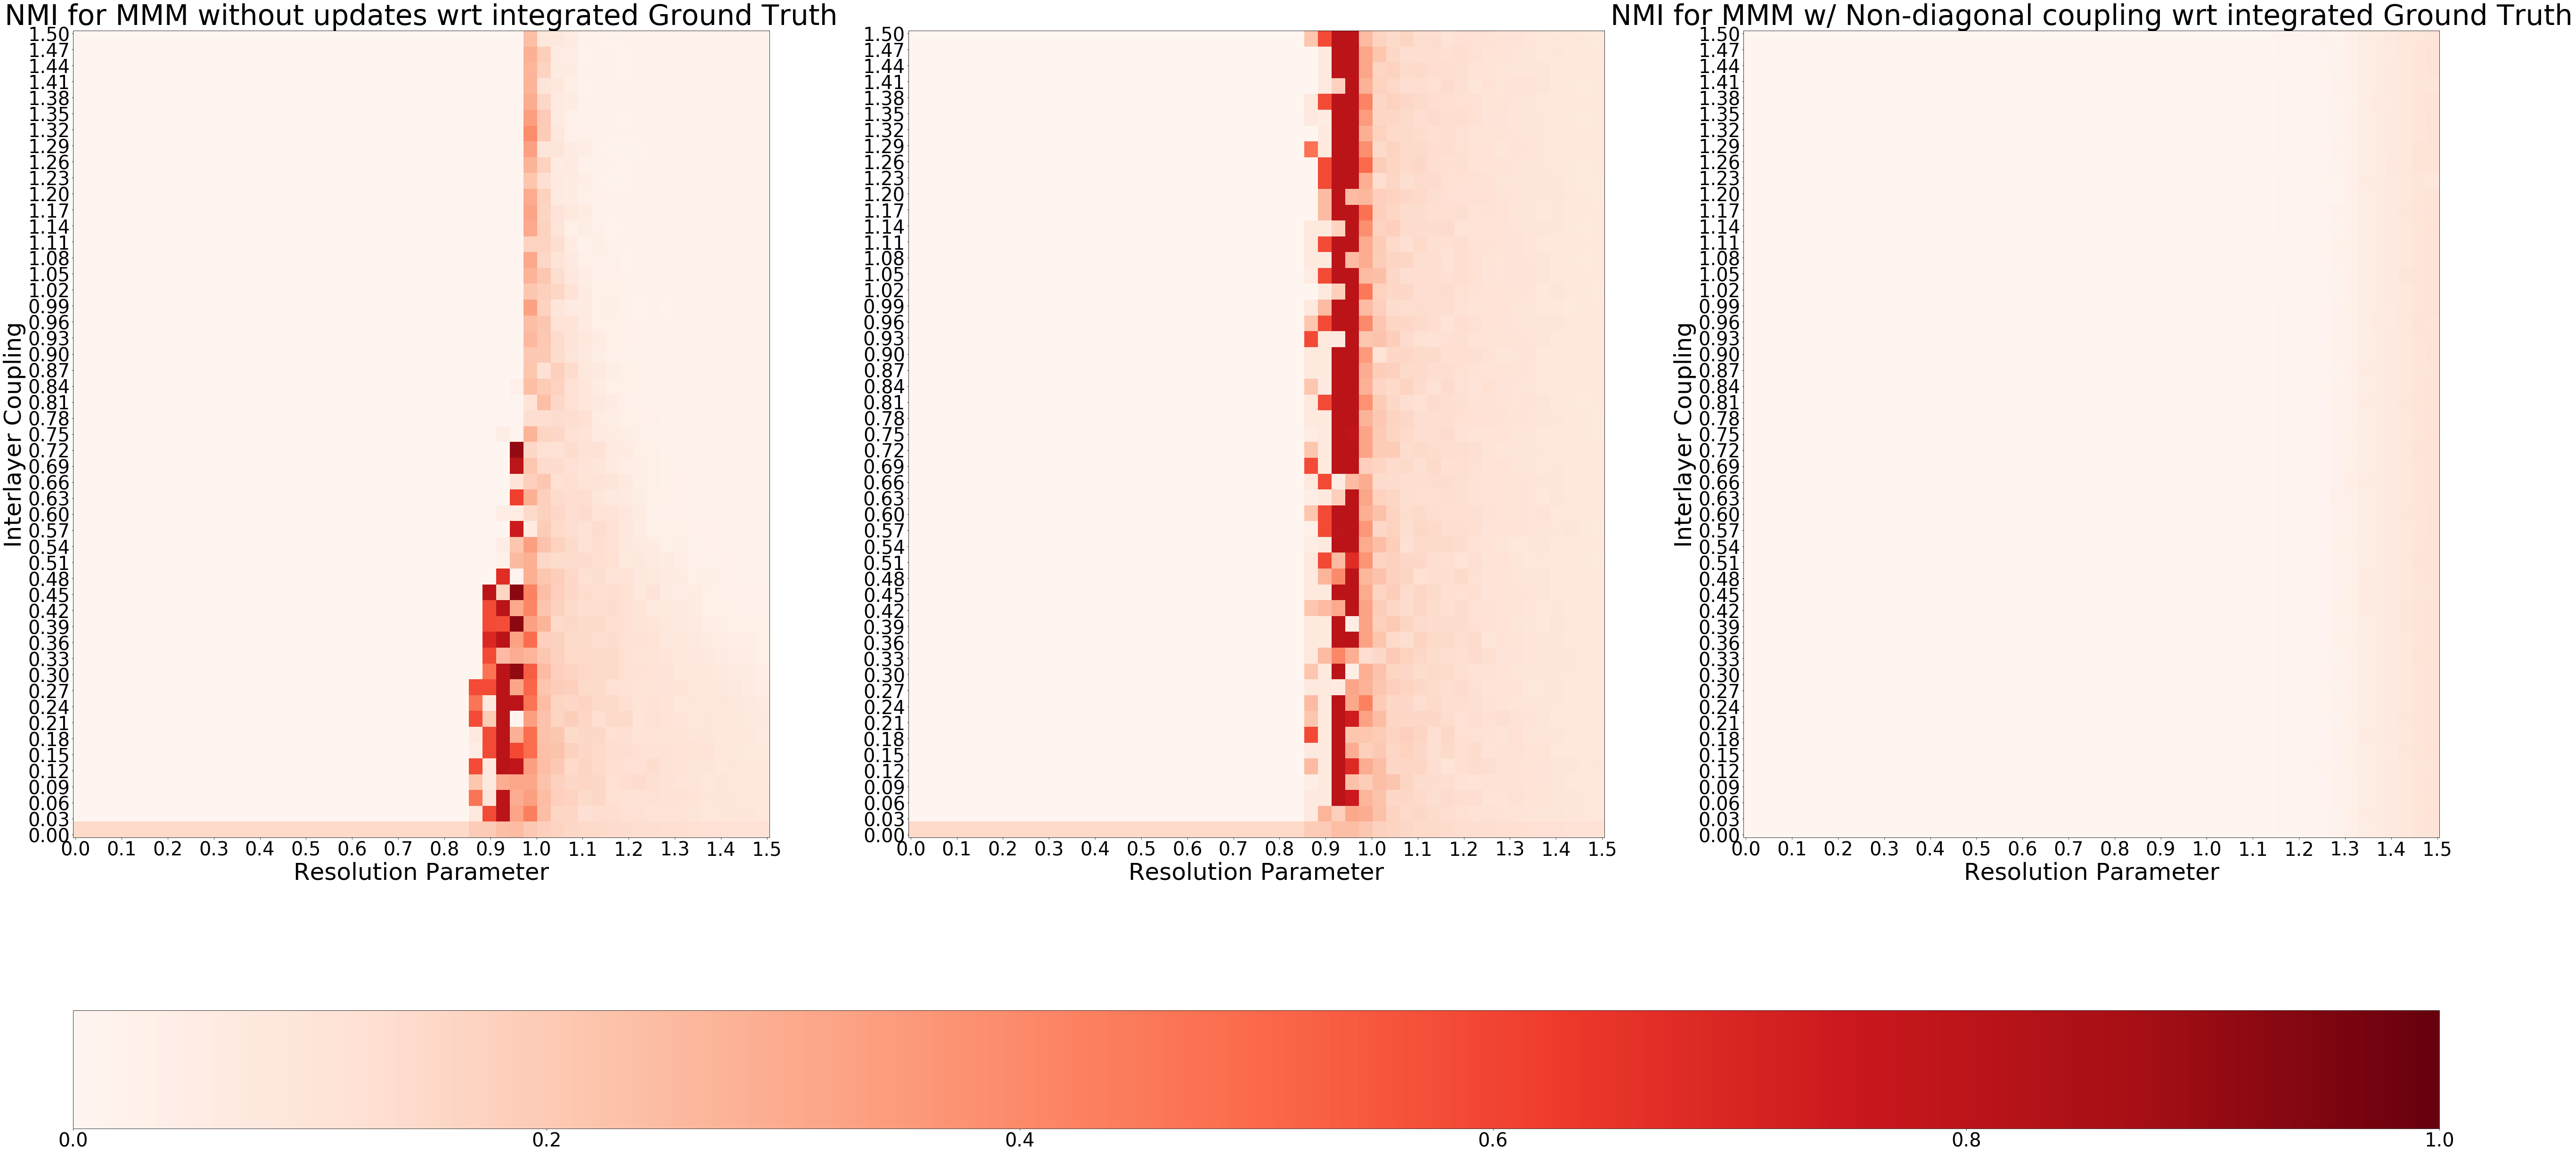

In [8]:
NMI1_no_updates = np.zeros((len(interlayers), len(resolutions)))
NMI1_local_updates = np.zeros((len(interlayers), len(resolutions)))
NMI1_global_updates = np.zeros((len(interlayers), len(resolutions)))
NMI1_nbr_updates = np.zeros((len(interlayers), len(resolutions)))

truth = 'integrated'

true_labels_integ_mmm = generate_ground_truth(G_ESCR_comm_sizes, method = 'integrated', pad = True, community_operation = 'grow')


for i in range(len(interlayers)):
    for j in range(len(resolutions)):
        NMI1_no_updates[i][j] = normalized_mutual_info_score(true_labels_integ_mmm, list(G_ESCR_labels0_mmm[i*len(resolutions)+j].astype(int)), average_method = 'max')
        NMI1_local_updates[i][j] = normalized_mutual_info_score(true_labels_integ_mmm, list(G_ESCR_labels1_mmm[i*len(resolutions)+j].astype(int)), average_method = 'max')
        NMI1_global_updates[i][j] = normalized_mutual_info_score(true_labels_integ_mmm, list(G_ESCR_labels2_mmm[i*len(resolutions)+j].astype(int)), average_method = 'max')
        NMI1_nbr_updates[i][j] = normalized_mutual_info_score(true_labels_integ_mmm, list(G_ESCR_labels3_mmm[i*len(resolutions)+j].astype(int)), average_method = 'max')

fig,ax = plt.subplots(1,3, figsize = (90,45))


normalize = Normalize(vmin=0, vmax=1)


c = ax[0].imshow(NMI1_no_updates, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

c = ax[1].imshow(NMI1_local_updates, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

c = ax[2].imshow(NMI1_nbr_updates, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


ax[0].set_title('NMI for MMM without updates wrt %s Ground Truth'%truth, fontsize = 60)
ax[0].set_xlabel('Resolution Parameter', fontsize = 50)
ax[0].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[0].set_xticks([i*0.1 for i in range(0,16)])
ax[0].set_yticks(interlayers)
ax[0].tick_params(axis = 'both', labelsize = 40)

#ax[1].set_title('NMI for MMM with local updates wrt %s Ground Truth'%truth, fontsize = 60)
ax[1].set_xlabel('Resolution Parameter', fontsize = 50)
#ax[1].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[1].set_xticks([i*0.1 for i in range(0,16)])
ax[1].set_yticks(interlayers)
ax[1].tick_params(axis = 'both', labelsize = 40)

ax[2].set_title('NMI for MMM w/ Non-diagonal coupling wrt %s Ground Truth'%truth, fontsize = 60)
ax[2].set_xlabel('Resolution Parameter', fontsize = 50)
ax[2].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[2].set_xticks([i*0.1 for i in range(0,16)])
ax[2].set_yticks(interlayers)
ax[2].tick_params(axis = 'both', labelsize = 40)
    
cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 40) 

#plt.tight_layout()

## Compare across heuristics--INfomap

In [15]:
path = '/Users/bengieru/MLN/Results/Comparison/G_ESCR/'

grid = 51
thresholds = np.linspace(0, 0.8, grid)
inters = np.linspace(0, 1.5, grid)


with open(path + 'infomap_labels_nbr_update.pkl', 'rb') as handle:
    G_ESCR_labels3_infomap = pickle.load(handle)
with open(path + 'infomap_labels_global_update.pkl', 'rb') as handle:
    G_ESCR_labels2_infomap = pickle.load(handle)
with open(path + 'infomap_labels_local_update.pkl', 'rb') as handle:
    G_ESCR_labels1_infomap = pickle.load(handle)
with open(path + 'infomap_labels_no_update.pkl', 'rb') as handle:
    G_ESCR_labels0_infomap= pickle.load(handle)
    
with open(path + 'comm_size.pkl', 'rb') as handle:
    G_ESCR_comm_size_infomap = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    G_ESCR_spikes = pickle.load(handle)

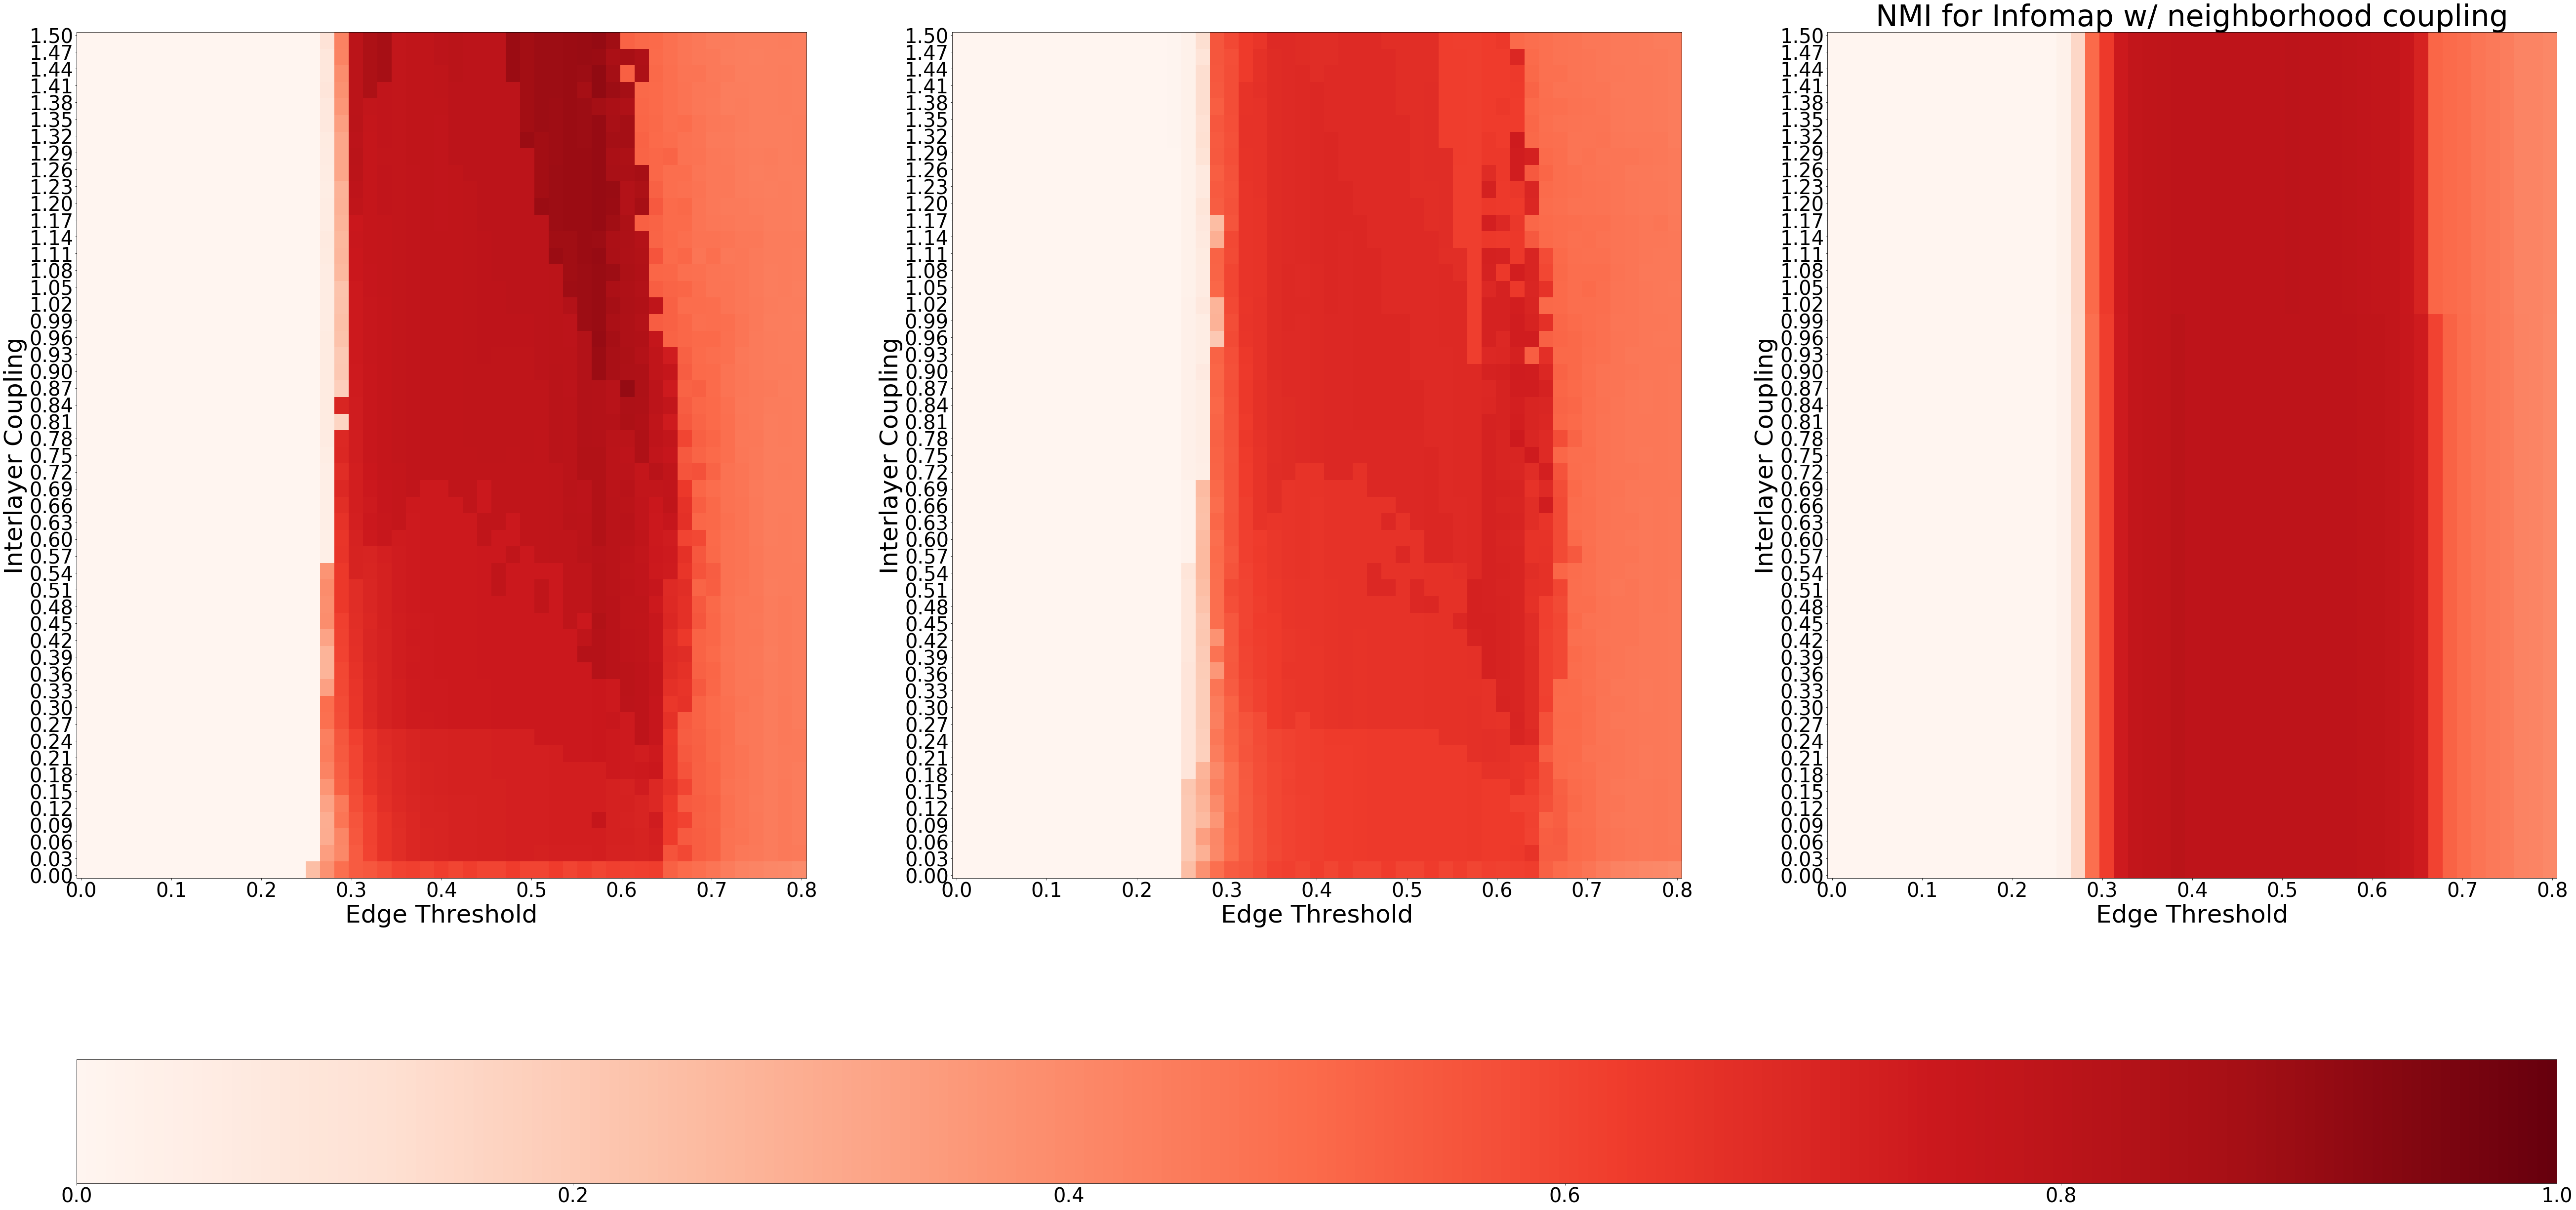

In [16]:
NMI1_no_updates = np.zeros((len(inters), len(thresholds)))
NMI1_local_updates = np.zeros((len(inters), len(thresholds)))
NMI1_global_updates = np.zeros((len(inters), len(thresholds)))
NMI1_neighborhood = np.zeros((len(inters), len(thresholds)))

truth = 'scattered'

true_labels_scat_info = generate_ground_truth(G_ESCR_comm_size_infomap, method = 'scattered', pad = True, community_operation = 'grow')


for i in range(len(inters)):
    for j in range(len(thresholds)):
        NMI1_no_updates[i][j] = normalized_mutual_info_score(true_labels_scat_info, list(G_ESCR_labels0_infomap[i*len(thresholds)+j].astype(int)), average_method = 'max')
        NMI1_local_updates[i][j] = normalized_mutual_info_score(true_labels_scat_info, list(G_ESCR_labels1_infomap[i*len(thresholds)+j].astype(int)), average_method = 'max')
        NMI1_global_updates[i][j] = normalized_mutual_info_score(true_labels_scat_info, list(G_ESCR_labels2_infomap[i*len(thresholds)+j].astype(int)), average_method = 'max')
        NMI1_neighborhood[i][j] = normalized_mutual_info_score(true_labels_scat_info, list(G_ESCR_labels3_infomap[i*len(thresholds)+j].astype(int)), average_method = 'max')


fig,ax = plt.subplots(1,3, figsize = (90,45))


normalize = Normalize(vmin=0, vmax=1)


c = ax[0].imshow(NMI1_no_updates, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [thresholds[0]-0.005, thresholds[-1]+0.005, inters[0]-0.005, inters[-1]+0.005])

c = ax[1].imshow(NMI1_local_updates, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds[0]-0.005, thresholds[-1]+0.005, inters[0]-0.005, inters[-1]+0.005])

c = ax[2].imshow(NMI1_neighborhood, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds[0]-0.005, thresholds[-1]+0.005, inters[0]-0.005, inters[-1]+0.005])


#ax[0].set_title('NMI for Infomap without updates wrt %s Ground Truth'%truth, fontsize = 60)
ax[0].set_xlabel('Edge Threshold', fontsize = 50)
ax[0].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[0].set_xticks([i*0.1 for i in range(0,9)])
ax[0].set_yticks(interlayers)
ax[0].tick_params(axis = 'both', labelsize = 40)

#ax[1].set_title('NMI for Infomap with local updates wrt %s Ground Truth'%truth, fontsize = 60)
ax[1].set_xlabel('Edge Threshold', fontsize = 50)
ax[1].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[1].set_xticks([i*0.1 for i in range(0,9)])
ax[1].set_yticks(interlayers)
ax[1].tick_params(axis = 'both', labelsize = 40)

ax[2].set_title('NMI for Infomap w/ neighborhood coupling', fontsize = 60)
ax[2].set_xlabel('Edge Threshold', fontsize = 50)
ax[2].set_ylabel('Interlayer Coupling', fontsize = 50)
ax[2].set_xticks([i*0.1 for i in range(0,9)])
ax[2].set_yticks(interlayers)
ax[2].tick_params(axis = 'both', labelsize = 40)
    
cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 40) 

#plt.tight_layout()

In [ ]:
np.savetxt('/Users/bengieru/MLN/Make_Figures/DPPM_landscape.txt', NMI1_neighborhood, delimiter=',')

## Run Consensus for each test-MMM

In [10]:
interlayers = np.linspace(0, 1.50, 51)
resolutions = np.linspace(0, 1.50, 51)
n = sum(G_ESCR_comm_sizes)##
t = 9
interlayers, resolutions

(array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
        0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
        0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
        1.32, 1.35, 1.38, 1.41, 1.44, 1.47, 1.5 ]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
        0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
        0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
        1.32, 1.35, 1.38, 1.41, 1.44, 1.47, 1.5 ]))

In [38]:
max_recovery1 = np.zeros((45,n*t))##
for i in range(1,16):##
    max_recovery1[(i-1)*3:(i)*3] = G_ESCR_labels0_mmm[i*len(interlayers)+30:i*len(interlayers)+33]##

In [39]:
consensus_partition1 = community_consensus_iterative(max_recovery1)##

In [40]:
comms, cmap, color = consensus_display(consensus_partition1, n, t)##

Text(0, 0.5, 'Node ID')

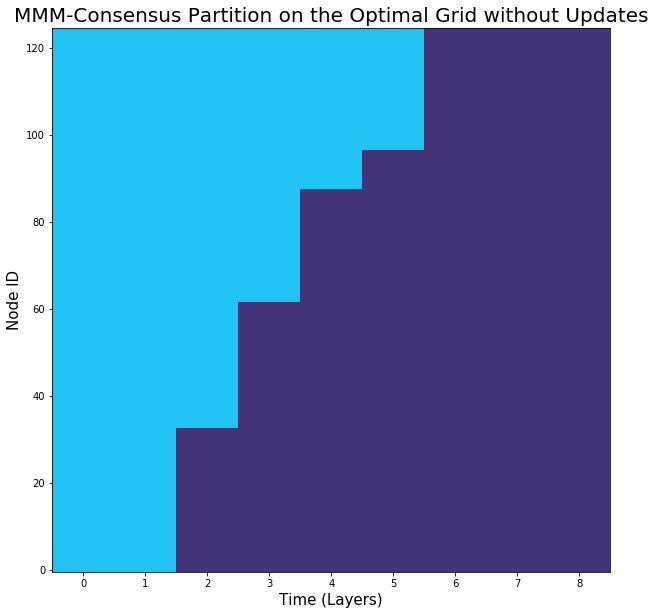

In [41]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(comms, interpolation = 'none', cmap = cmap, 
          aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
ax.set_title('MMM-Consensus Partition on the Optimal Grid without Updates', fontsize = 20)
ax.set_xlabel('Time (Layers)', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)

In [42]:
max_recovery2 = np.zeros((100,n*t))##
for i in range(1,51):##
    max_recovery2[(i-1)*2:(i)*2] = G_ESCR_labels1_mmm[i*len(interlayers)+31:i*len(interlayers)+33]##

In [43]:
consensus_partition2 = community_consensus_iterative(max_recovery2)##

In [44]:
comms, cmap, color = consensus_display(consensus_partition2, n, t)##

Text(0, 0.5, 'Node ID')

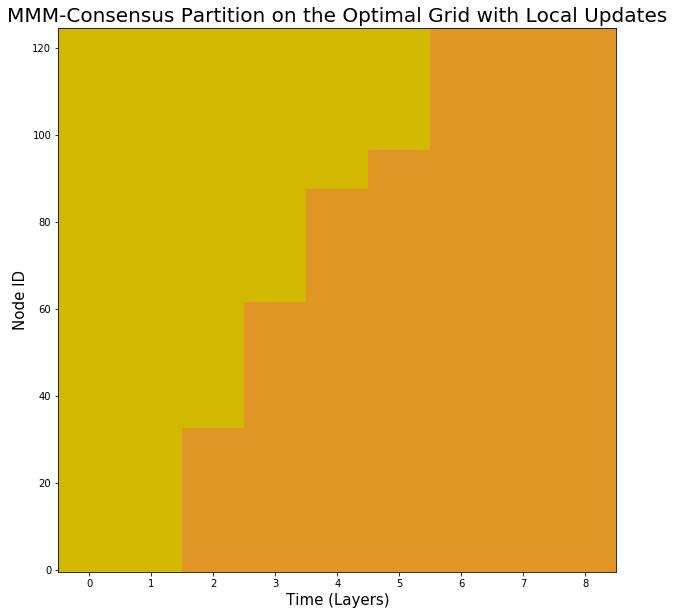

In [46]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(comms, interpolation = 'none', cmap = cmap, 
          aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
ax.set_title('MMM-Consensus Partition on the Optimal Grid with Local Updates', fontsize = 20)
ax.set_xlabel('Time (Layers)', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)

In [11]:
max_recovery3 = np.zeros((150,n*t))##
for i in range(1,31):##
    max_recovery3[(i-1)*5:(i)*5] = G_ESCR_labels3_mmm[i*len(interlayers)+46:i*len(interlayers)+51]##

In [12]:
consensus_partition3 = community_consensus_iterative(max_recovery3)##

In [13]:
comms, cmap, color = consensus_display(consensus_partition3, n, t)##

Text(0, 0.5, 'Node ID')

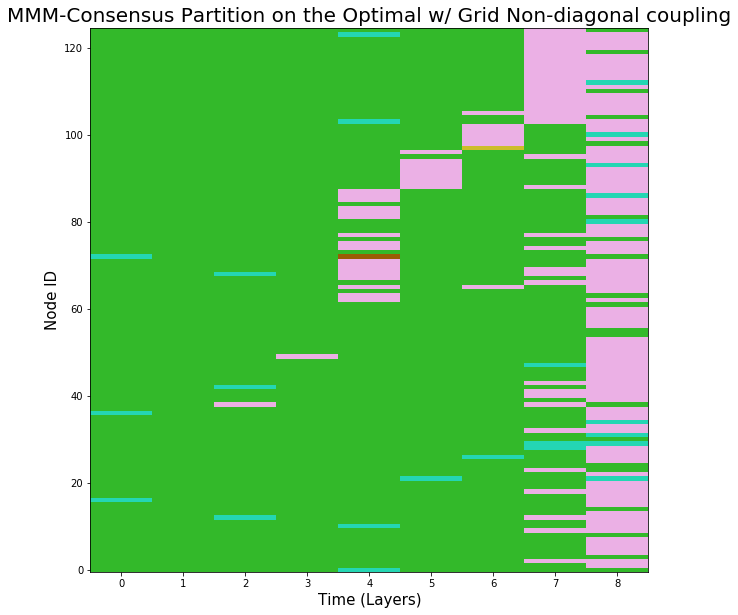

In [16]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(comms, interpolation = 'none', cmap = cmap, 
          aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
ax.set_title('MMM-Consensus Partition on the Optimal w/ Grid Non-diagonal coupling', fontsize = 20)
ax.set_xlabel('Time (Layers)', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)

## Run Consensus for each test- INfomap

In [4]:
grid = 51
thresholds = np.linspace(0, 0.8, grid)
inters = np.linspace(0, 1.5, grid)
n = sum(G_ESCR_comm_size_infomap)##
t = 9
thresholds, inters

(array([0.   , 0.016, 0.032, 0.048, 0.064, 0.08 , 0.096, 0.112, 0.128,
        0.144, 0.16 , 0.176, 0.192, 0.208, 0.224, 0.24 , 0.256, 0.272,
        0.288, 0.304, 0.32 , 0.336, 0.352, 0.368, 0.384, 0.4  , 0.416,
        0.432, 0.448, 0.464, 0.48 , 0.496, 0.512, 0.528, 0.544, 0.56 ,
        0.576, 0.592, 0.608, 0.624, 0.64 , 0.656, 0.672, 0.688, 0.704,
        0.72 , 0.736, 0.752, 0.768, 0.784, 0.8  ]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
        0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
        0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
        1.32, 1.35, 1.38, 1.41, 1.44, 1.47, 1.5 ]))

In [52]:
max_recovery3 = np.zeros((44,n*t))##
for i in range(40,51):##
    max_recovery3[(i-40)*4:(i-39)*4] = G_ESCR_labels0_infomap[i*len(inters)+32:i*len(inters)+36]##

In [53]:
consensus_partition3 = community_consensus_iterative(max_recovery3)##

In [54]:
comms, cmap, color = consensus_display(consensus_partition3, n, t)##

Text(0, 0.5, 'Node ID')

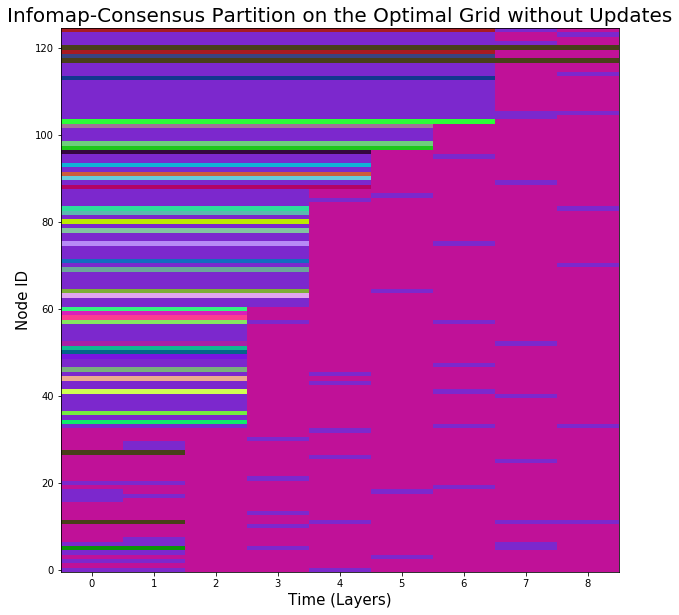

In [55]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(comms, interpolation = 'none', cmap = cmap, 
          aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
ax.set_title('Infomap-Consensus Partition on the Optimal Grid without Updates', fontsize = 20)
ax.set_xlabel('Time (Layers)', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)

In [56]:
max_recovery4 = np.zeros((28,n*t))##
for i in range(44,51):##
    max_recovery4[(i-44)*4:(i-43)*4] = G_ESCR_labels1_infomap[i*len(inters)+34:i*len(inters)+38]##

In [57]:
consensus_partition4 = community_consensus_iterative(max_recovery4)##

In [58]:
comms, cmap, color = consensus_display(consensus_partition4, n, t)##

Text(0, 0.5, 'Node ID')

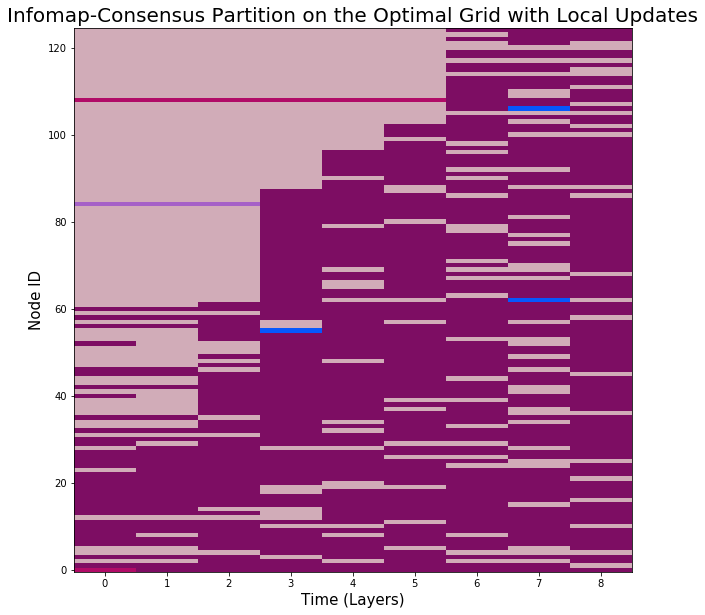

In [60]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(comms, interpolation = 'none', cmap = cmap, 
          aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
ax.set_title('Infomap-Consensus Partition on the Optimal Grid with Local Updates', fontsize = 20)
ax.set_xlabel('Time (Layers)', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)

In [5]:
max_recovery5 = np.zeros((33,n*t))##
for i in range(1,34):##
    max_recovery5[(i-1)*1:(i)*1] = G_ESCR_labels3_infomap[i*len(inters)+24:i*len(inters)+25]##

In [6]:
consensus_partition5 = community_consensus_iterative(max_recovery5)##

In [7]:
comms, cmap, color = consensus_display(consensus_partition5, n, t)##

Text(0, 0.5, 'Node ID')

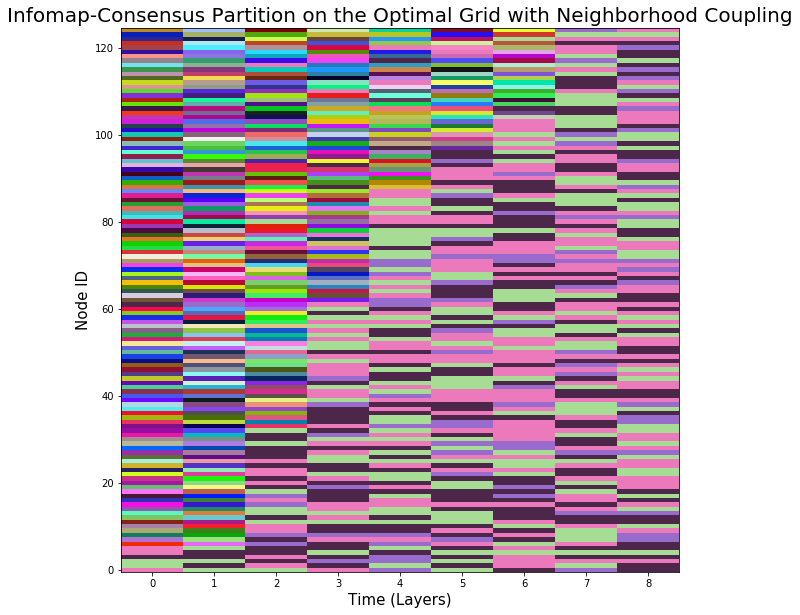

In [8]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(comms, interpolation = 'none', cmap = cmap, 
          aspect = 'auto', origin = 'lower', extent = [-0.5,t-0.5,-0.5,n-0.5])
ax.set_title('Infomap-Consensus Partition on the Optimal Grid with Neighborhood Coupling', fontsize = 20)
ax.set_xlabel('Time (Layers)', fontsize = 15)
ax.set_ylabel('Node ID', fontsize = 15)